# Прогнозирование оттока клиентов телеком компании

_____
**Описание исследования.**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. 
Заказчик планирует начать предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь (телефон можно подключить к нескольким линиям одновременно);

- Интернет (подключение может быть двух типов: через телефонную линию (`DSL`) или оптоволоконный кабель (`Fiber optic`)).

Также клиентам оператора доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);

- Выделенная линия технической поддержки (`TechSupport`);

- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);

- Стриминговое телевидение (StreamingTV) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

_____
**Цель исследования.**
    
Разработка модели, которая позволит предсказывать, разорвёт ли абонент договор. 
    
_____
**Задачи исследования.**

Для того, чтобы достичь поставленной цели необходимо решить ряд задач:

- загрузить данные и провести их первичный осмотр;
- объединить данные; 
- провести исследовательский анализ полученных данных (проверить данные на наличие ошибок);
- построить модель, качество которой будет удовлетворять требованиям заказчика (test sample ROC-AUC>=0.85);
- протестировать полученную модель на тестовой выборке и сделать выводы.

_____
**Исходные данные.**

`contract_new.csv` :
таблица, которая содержит информацию о договоре;

`internet_new.csv` :
таблица с персональными данными клиента;

`personal_new.csv` :
таблица с информацией об интернет-услугах;

`phone_new.csv` : 
таблица с информацией об услугах телефонии.

In [1]:
RANDOM_STATE = 201025

In [2]:
TEST_SIZE = 0.25

In [3]:
df_sent_date = '2020-02-01'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Вывел основные константы.

In [4]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_colwidth', None)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Импортировал билблиотеки.

# Загрузка данных

In [7]:
main_link = 'C:/Users/igor.grenaderov/datasets/'

In [8]:
contract_new = pd.read_csv(main_link + 'contract_new.csv')

In [9]:
internet_new = pd.read_csv(main_link + 'internet_new.csv')

In [10]:
personal_new = pd.read_csv(main_link + 'personal_new.csv')

In [11]:
phone_new = pd.read_csv(main_link + 'phone_new.csv')

In [12]:
contract_new.name = 'contract_new'

In [13]:
internet_new.name = 'internet_new'

In [14]:
personal_new.name = 'personal_new'

In [15]:
phone_new.name = 'phone_new'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Загрузил данные, полученным датафреймам присвоил имена.

## Загрузка данных. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

Загрузил данные, менять кодирование или указывать разделители не пришлось.

# Исследовательский анализ и предобработка данных

In [16]:
df_list = [contract_new, internet_new, personal_new, phone_new]

In [17]:
def df_name(df):
    try:
        return df.name
    except AttributeError:
        return 'Unnamed'

In [18]:
def informer(lst):
    for df in lst:
        print('-'*120)
        
        display(df.sample(5).style.set_caption(f"5 случайных строк из датафрейма '{df_name(df)}'"))
        print('-'*120)
        
        print(f"Основная информация о датафрейме '{df_name(df)}':")
        print('\n')
        df.info()

        print('\n')
        print('-'*120)

        print(f"Количество дубликатов в '{df.name}': {df.duplicated(subset=df.columns).sum()}")
        print(f"Количество пропусков в '{df.name}': {sum([df[i].isna().sum() for i in df.columns])}")        
        print('-'*120)
        print('\n'*3)

In [19]:
informer(df_list)

------------------------------------------------------------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1081,1751-NCDLI,2016-04-01,No,Month-to-month,Yes,Electronic check,98.850000,4547.1
5560,1346-PJWTK,2015-01-01,No,Month-to-month,No,Credit card (automatic),94.150000,5743.15
3586,8722-NGNBH,2019-07-01,No,Month-to-month,No,Mailed check,40.000000,288.4
1371,6567-HOOPW,2019-11-01,No,Month-to-month,Yes,Electronic check,79.200000,237.6
57,5067-XJQFU,2014-08-01,No,One year,Yes,Electronic check,108.450000,7730.32


------------------------------------------------------------------------------------------------------------------------
Основная информация о датафрейме 'contract_new':


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


------------------------------------------------------------------------------------------------------------------------
Количество дубликатов в 'contract_new': 0
Количество пропусков в 'contract_

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2835,6479-VDGRK,DSL,Yes,Yes,Yes,Yes,Yes,Yes
4999,3258-ZKPAI,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
3179,0757-WCUUZ,DSL,No,No,Yes,No,No,Yes
4375,1660-HSOOQ,DSL,No,No,Yes,No,No,No
5480,2108-XWMPY,DSL,Yes,Yes,No,No,No,No


------------------------------------------------------------------------------------------------------------------------
Основная информация о датафрейме 'internet_new':


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


------------------------------------------------------------------------------------------------------------------------
Количество дубликатов в 'internet_new': 0
Количество пропусков в 'internet_new': 0
--------------

,customerID,gender,SeniorCitizen,Partner,Dependents
1099,6921-OZMFH,Male,0,Yes,Yes
5457,9496-IVVRP,Female,0,Yes,Yes
6342,3384-CTMSF,Male,0,Yes,No
4102,1919-RTPQD,Male,0,Yes,Yes
6275,0885-HMGPY,Male,0,No,No


------------------------------------------------------------------------------------------------------------------------
Основная информация о датафрейме 'personal_new':


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


------------------------------------------------------------------------------------------------------------------------
Количество дубликатов в 'personal_new': 0
Количество пропусков в 'personal_new': 0
------------------------------------------------------------------------------------------------------------------------




--------------------------------------

,customerID,MultipleLines
5017,9644-KVCNC,Yes
904,1374-DMZUI,Yes
6080,7359-SSBJK,No
5322,9584-EXCDZ,No
5541,1228-ZLNBX,Yes


------------------------------------------------------------------------------------------------------------------------
Основная информация о датафрейме 'phone_new':


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


------------------------------------------------------------------------------------------------------------------------
Количество дубликатов в 'phone_new': 0
Количество пропусков в 'phone_new': 0
------------------------------------------------------------------------------------------------------------------------






</font><font color='Blue'><b>Коммментарий</b></font><br>

Написал функцию для отображения основной информации о датафреймах, которые поступают в функцию в виде списка. Видно, что явных дубликатов в датафреймах нет, но есть ошибки в колонках `'TotalCharges'`, `'BeginDate'` и `'EndDate'`.

In [20]:
def col_name_reb(column):

    pattern = r"([a-z])(?=[A-Z])"
    column = re.sub(pattern, r"\1_", column).lower()

    return column.lower()

In [21]:
for df in df_list:
    df.columns = [col_name_reb(col) for col in df.columns]

</font><font color='Blue'><b>Коммментарий</b></font><br>

Сменил `CamelCase` на `змеиный_регистр` в наименованиях колонок в датафреймах.

## Исследовательский анализ и предобработка данных. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

Выше была отображена основная информации о загруженных датафреймах.  В колонках 'TotalCharges', 'BeginDate' и 'EndDate' содежатся данные с некорретными типами данных. Явные дубликаты не обнаружил. 

На этом этапе исправил только ошибки в наименовании колонок, ошибки в типах исправлю после объединения таблиц.

# Объединение данных

In [22]:
for df in df_list:
    print(f'Размерность датафрейма {df.name}: {df.shape}')

Размерность датафрейма contract_new: (7043, 8)
Размерность датафрейма internet_new: (5517, 8)
Размерность датафрейма personal_new: (7043, 5)
Размерность датафрейма phone_new: (6361, 2)


</font><font color='Blue'><b>Коммментарий</b></font><br>

Проверил, какого размера каждая из таблиц - размеры отличаются.

In [23]:
def id_check(lst):

    id_list = []
    for df in lst:
        id_list += df['customer_id'].tolist()
    
    return len(set(id_list))

In [24]:
print(f"Количество уникальных значений в колонке 'customer_id': {id_check(df_list)}")

Количество уникальных значений в колонке 'customer_id': 7043


</font><font color='Blue'><b>Коммментарий</b></font><br>

Проверил, соответствуют ли id клиентов из меньших таблиц id клинтов из большей: они соответствуют, так как количество уникальных значений id со всех датафреймов такое же, как количество из большего датафрейма.

In [25]:
def joiner(lst, id_):

    res_df = lst[0].set_index(id_)
    
    for df in lst[1:]:
        res_df = res_df.join(df.set_index(id_), how='left', on = id_)

    res_df.name = 'joined_df'
    
    return res_df

In [26]:
joined_df = joiner(df_list, 'customer_id')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Последовательно соединил все датафреймы в `joined_df` при помощи `left join`  для того, чтобы сохранить все наблюдения из больших таблиц. В качестве ключа использовал `'customer_id'`.

## Объединение данных. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>


Объединил датафреймы в один общий датафрейм по ключу с `id пользователя`. Перед объединением таблиц проверил, какого размера каждая из таблиц - размеры отличаются, поэтому для объединения использовал `left-join`, чтобы не потерять имеющиеся данные из больших таблиц и не плодить лишние строки.

# Исследовательский анализ и предобработка данных объединённого датафрейма

In [27]:
informer([joined_df])

------------------------------------------------------------------------------------------------------------------------


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
2208-NQBCT,2017-12-01,No,Month-to-month,No,Electronic check,81.950000,2130.7,Fiber optic,Yes,Yes,No,No,No,No,Female,0,Yes,Yes,No
7980-MHFLQ,2014-02-01,2015-05-01,Two year,No,Mailed check,24.900000,373.5,nan,nan,nan,nan,nan,nan,nan,Female,0,Yes,Yes,Yes
0927-LCSMG,2019-06-01,No,Month-to-month,No,Mailed check,74.650000,639.0,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
1761-AEZZR,2019-12-01,No,Month-to-month,Yes,Electronic check,79.550000,175.01,Fiber optic,No,No,No,No,Yes,No,Male,0,No,No,No
6087-YPWHO,2014-02-01,No,Two year,No,Mailed check,68.150000,5054.0,DSL,Yes,Yes,Yes,Yes,No,No,Male,0,Yes,No,Yes


------------------------------------------------------------------------------------------------------------------------
Основная информация о датафрейме 'joined_df':


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   internet_service   5517 non-null   object 
 8   online_security    5517 non-null   object 
 9   online_backup      5517 non-null   object 
 10  device_protection  5517 non-null   object 
 11  tech_support       5517 non-null   object 
 12  streaming_tv       5517 non-null   ob

In [28]:
joined_df[joined_df.duplicated(keep=False)].style\
    .set_caption(f'Дубликаты датафрейма "{joined_df.name}"')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.050000,8211.6,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
2866-IKBTM,2020-01-01,No,Month-to-month,No,Mailed check,19.550000,19.55,nan,nan,nan,nan,nan,nan,nan,Female,0,No,No,No
4312-KFRXN,2014-02-01,No,Two year,No,Mailed check,25.400000,1828.8,nan,nan,nan,nan,nan,nan,nan,Male,0,Yes,No,Yes
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.550000,19.55,nan,nan,nan,nan,nan,nan,nan,Female,0,No,No,No
0673-IGUQO,2020-01-01,No,Month-to-month,No,Mailed check,20.450000,20.45,nan,nan,nan,nan,nan,nan,nan,Male,0,No,No,No
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.450000,20.45,nan,nan,nan,nan,nan,nan,nan,Male,0,No,No,No
3892-NXAZG,2014-02-01,No,Two year,Yes,Credit card (automatic),114.050000,8211.6,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
8774-GSBUN,2014-02-01,No,Two year,No,Mailed check,25.400000,1828.8,nan,nan,nan,nan,nan,nan,nan,Male,0,Yes,No,Yes


In [29]:
joined_df.drop_duplicates(inplace=True)

</font><font color='Blue'><b>Коммментарий</b></font><br>

После объединения датафреймов, функция `informer` показала, что в датафрейме образовались дубликаты. Видно, что дубликаты образовались из - за того, что в датафрейме теперь нет колонки с `'customer_id'`. Дубликаты необходимо удалить.

In [30]:
joined_df.sample(25,random_state=RANDOM_STATE).style\
    .set_caption(f'25 случайных строк из датафрейма "{joined_df.name}"')\
    .set_properties(**{'border-left':  '3px dashed blue'}, subset=internet_new.columns[1])\
    .set_properties(**{'border-right':  '3px dashed blue'}, subset=internet_new.columns[-1])\
    .set_properties(**{'border-left':  '3px dashed blue'}, subset=phone_new.columns[1])\
    .set_properties(**{'border-right':  '3px dashed blue'}, subset=phone_new.columns[-1])\
   

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
8318-LCNBW,2017-03-01,No,One year,No,Credit card (automatic),53.150000,1953.26,DSL,Yes,No,Yes,No,Yes,Yes,Male,0,Yes,No,nan
6496-JDSSB,2019-06-01,No,Month-to-month,Yes,Bank transfer (automatic),80.000000,691.2,Fiber optic,No,No,No,No,Yes,No,Female,0,No,No,No
9938-TKDGL,2014-06-01,No,Two year,Yes,Electronic check,99.550000,7310.95,Fiber optic,Yes,No,No,Yes,Yes,Yes,Male,0,Yes,Yes,No
2753-JMMCV,2014-09-01,2016-07-01,Two year,Yes,Credit card (automatic),74.200000,1632.4,DSL,No,Yes,Yes,Yes,No,Yes,Male,0,No,No,Yes
9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.700000,8257.51,Fiber optic,Yes,No,Yes,No,Yes,Yes,Male,0,No,Yes,Yes
7977-HXJKU,2018-05-01,No,Two year,No,Mailed check,19.600000,411.6,nan,nan,nan,nan,nan,nan,nan,Male,0,No,Yes,No
5260-UMPWX,2017-12-01,No,Month-to-month,Yes,Credit card (automatic),20.250000,558.09,nan,nan,nan,nan,nan,nan,nan,Female,0,Yes,Yes,No
5130-IEKQT,2017-10-01,2019-10-01,Month-to-month,No,Mailed check,105.950000,2720.8,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,No,No,Yes
1640-PLFMP,2020-01-01,No,Month-to-month,Yes,Electronic check,70.250000,70.25,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


</font><font color='Blue'><b>Коммментарий</b></font><br>


После объединения датафреймов образовались пропуски, которые я подсветил в таком формате: <code style='background-color : #FFC0CB'>nan</code> , а <font><font color=blue>синим пунктиром </font> выделил колонки датафреймов ( `'internet_new'` и `'phone_new'` ), которые имели меньшую размерность отностительно основного датафрейма ( `'contract_new'` ). В таблице из 25 случайных строк объединенного датафрейма видно, что пропуски образовались в строках из меньших датафреймов.

In [31]:
joined_df.fillna('unknown', inplace=True)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Заменил пропуски  на заглушку `'unknown'`, так как заполнить пропуски значениями из имеющихся таблиц мы не можем поскольку не знаем причину, по которой не для всех клиентов имеются данные. К примеру, некий клиент может иметь подключение телефона к нескольким линиям одновременно, а мы заполним пропуск значением 'не имеет', очевидно, что это негативно скажется на качестве предсказания модели, если этот признак будет хоть сколько нибудь значимым.

In [32]:
joined_df[joined_df['total_charges']==' '].style.set_caption('Строки с неявными пропусками')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.550000,,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,unknown
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.250000,,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Male,0,No,Yes,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.850000,,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.750000,,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Male,0,Yes,Yes,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.050000,,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,unknown
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.850000,,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Male,0,Yes,Yes,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.350000,,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Male,0,Yes,Yes,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.000000,,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Female,0,Yes,Yes,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.700000,,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Male,0,Yes,Yes,No


</font><font color='Blue'><b>Коммментарий</b></font><br>
    Отобразил строки, в которых были неявные пропуски. Можно заметить, что у этих абонентов оплата происходит раз в два года, а дата начала действия договора 2020-02-01, как и дата сбора информации о договорах, поэтому данных об общих расходах абонента еще не появилось. Заполнить пропуски в колонке с общими расходами значениями из колонки с расходами за месяц нельзя, поэтому просто удалил эти строки.

In [33]:
missing_index = joined_df[joined_df['total_charges']==' '].index

In [34]:
joined_df.drop(index=missing_index, inplace=True)

In [35]:
joined_df['total_charges'] = joined_df['total_charges'].astype('float64')

In [36]:
joined_df['monthly_charges'] = joined_df['monthly_charges'].astype('float64')

</font><font color='Blue'><b>Коммментарий</b></font><br>
Удалил строки с неявными пропусками.

In [37]:
joined_df['left'] = joined_df['end_date'].apply(lambda x: 0 if x=="No" else 1)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил целевой признак. После его добавления необходимо будет удалить признак `end_date`, чтобы избежать утечки целевого признака 🙈. 

In [38]:
joined_df['begin_date'] = pd.to_datetime(joined_df['begin_date'], format='%Y-%m-%d')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Сменил формат в столбце `'begin_date'` на формат даты и времени еще до удаления, так как ниже на его основе будет сформирован входной признак `'days_reg'`.

In [39]:
def date_d(start, end):

    end = end.apply(lambda x: df_sent_date if x=="No" else x)

    end = pd.to_datetime(end, format='%Y-%m-%d')

    delta = end-start 
    
    return delta.dt.days

In [40]:
joined_df['days_reg'] = date_d(joined_df['begin_date'], joined_df['end_date'])

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил новый столбец с количеством дней (`'days_reg'`), в течение которого абонент пользуется услугами компании. Такие признаки, как день года или день недели добавить не получится и вот почему:


Представьте, что вам в понедельник 2020-02-03 показали данные о клиенте и попросили предположить, уйдет он или нет. Данные будут такие: длительность контракта - четыре дня, день недели заключения контракта - воскресенье. Вы также знаете, что данные были выгруженны из базы 2020-02-01. Открыв календарь вы сразу догадаетесь, что клиент уже расторг договор. Похожая ситуация будет и в случае с моделью, она найдет связь для таких случаев и выдаст значение roc-auc близкое к единице (0.98 - валид, 0.99 - тест, если быть точным), но при использовании модели для прогноза на данных с датой загрузки после 2020-02-01 результат будет намного хуже.

In [41]:
joined_df['day_of_year'] = joined_df['begin_date'].dt.dayofyear

</font><font color='Blue'><b>Коммментарий</b></font><br>
    Добавил признак с днем года, для демонстрации того, что на матрице эта ошибка не видна и эта проблема определяется скорее логически.

In [42]:
phik_overview = phik_matrix(joined_df, interval_cols = ['days_reg', 'monthly_charges', 'total_charges'])

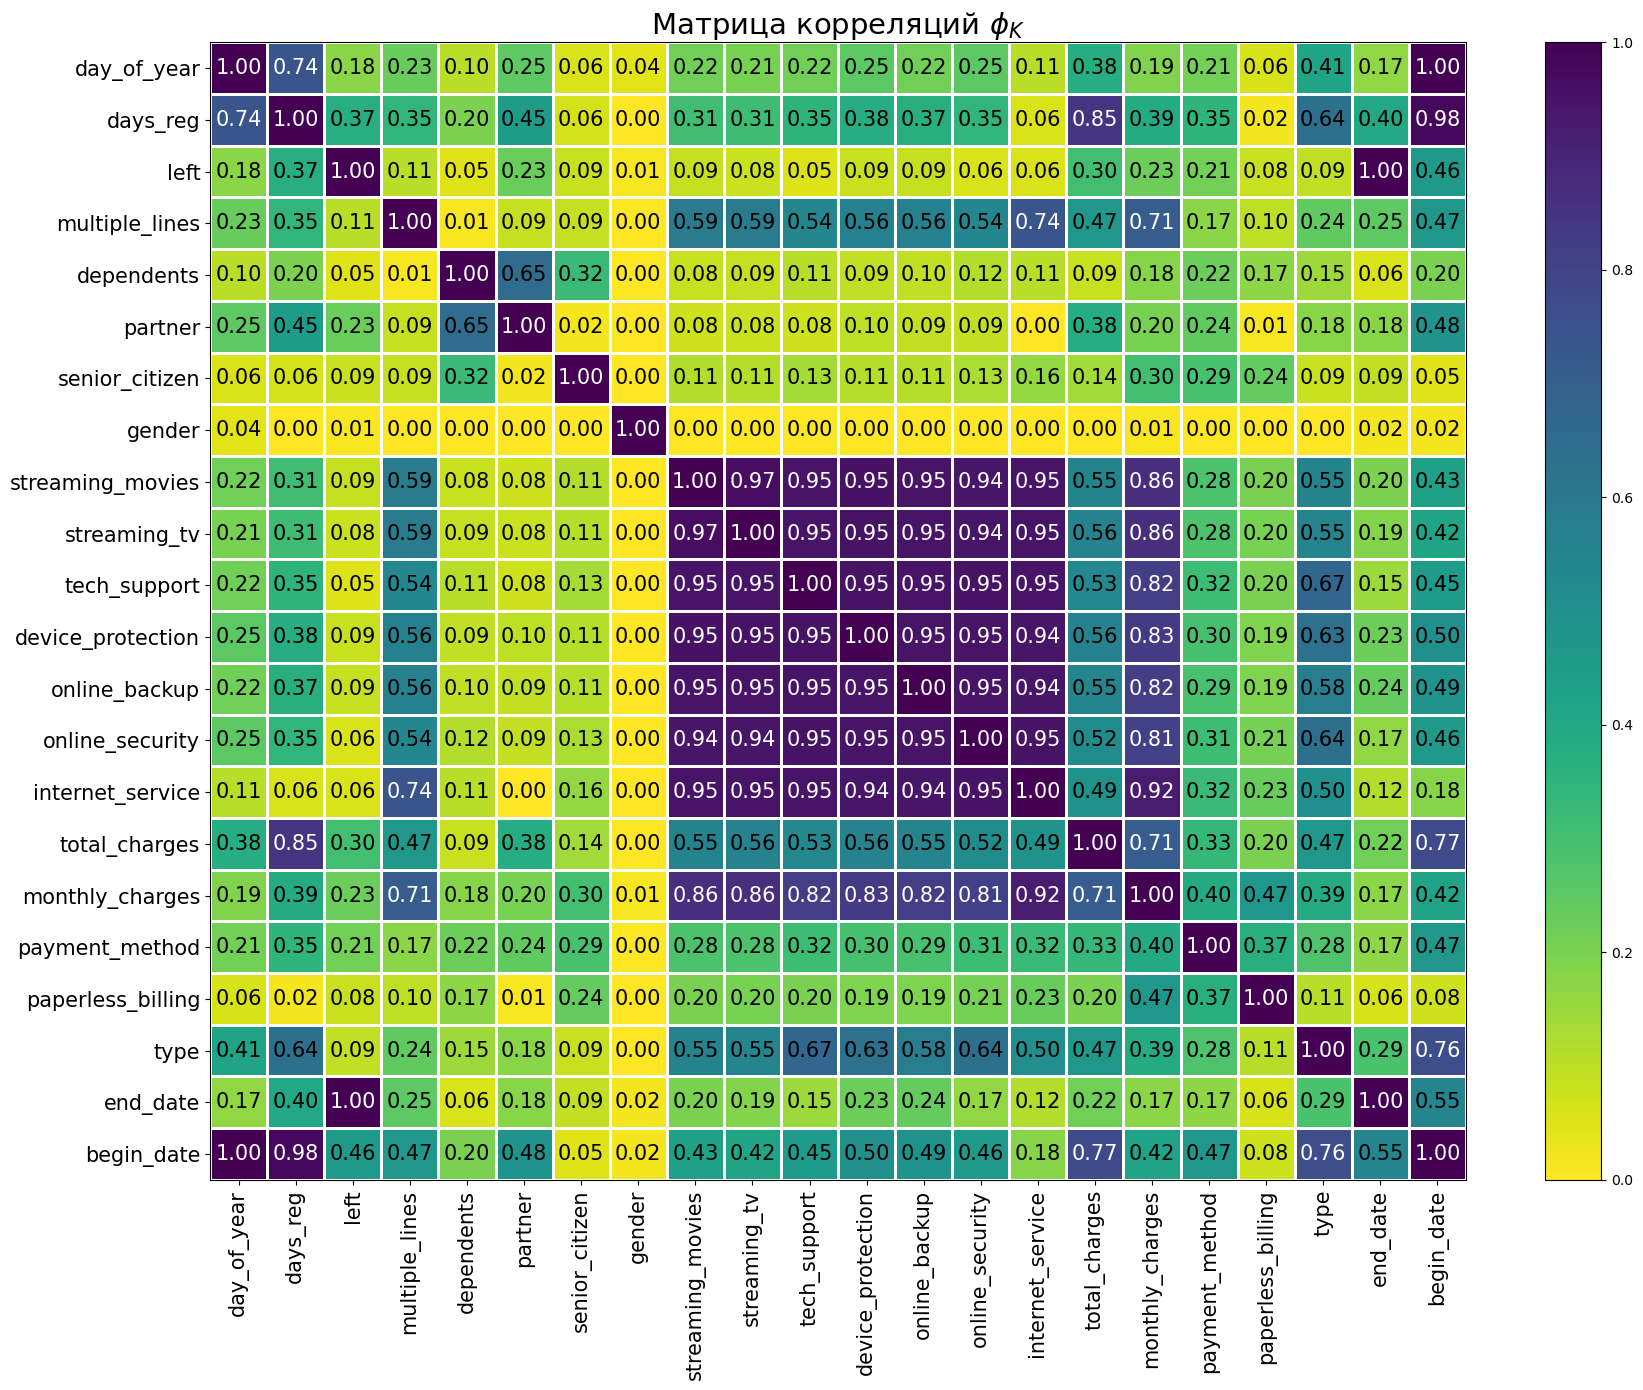

In [43]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='viridis_r',
    title=r'Матрица корреляций $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
)

In [44]:
del joined_df['day_of_year']

</font><font color='Blue'><b>Коммментарий</b></font><br>

Столбец с днем года удалил только после построения матрицы корреляций для того, чтобы убедиться, что признак с длительностью контракта имеет большее значение, чем день года заключения контракта.

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил матрицу корреляций для значений из основного датафрейма. На основе диаграммы можно сделать вывод о том, что самыми значимыми признаками из датафрейма можно считать: 
 * дата заключения договора;
 * длительность договора;
 * общее количество расходов абонента;
 * семейное положение абонента.

Все признаки, которые попали в данные имееют корреляцию с целевым. Признаки с информацией об интернет - услугах имеют очень высокую корреляцию между собой, поэтому часть из них нужно либо удалить, либо объединить.

In [45]:
joined_df['tarif_change'] = joined_df['monthly_charges']!= (joined_df['total_charges']/joined_df['days_reg'])*31

In [46]:
joined_df['tarif_change'] = joined_df['tarif_change'].apply(lambda x: 0 if x==False else 1)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил признак `'tarif_change'`, который показывает, менял ли пользователь тариф.

In [47]:
tuple_plt=(
    ('type', 'Тип оплаты', ('ежемес.','раз в 2 года','раз в год')),
    ('paperless_billing', 'Электронный расчётный лист', ('получает', 'не получает')),
    ('payment_method', 'Тип платежа', ('эл.\nчек', 'ч/з\nпочту', 'банк.\nпер.', 'пер.\nс карты')),
    ('gender', 'Гендерная принадлежность', ('жен.', 'муж.')),
    ('senior_citizen', 'Является ли абонент\nпенсионером', ('не явл.', 'явл.')),
    ('partner', 'Есть ли у абонента\nсупруг или супруга', ('да', 'нет')),
    ('dependents', 'Есть ли у абонента дети', ('нет', 'да')),
    ('internet_service', 'Тип подключения', ('оптовол.', 'тел. линия', 'неизв.')),
    ('online_security', 'Подключение блокировки\nопасных сайтов', ('нет', 'да', 'неизв.')),
    ('online_backup', 'Подключение облачного\nхранилища файлов', ('нет', 'да', 'неизв.')),
    ('device_protection', 'Подключение антивируса',('нет', 'да', 'неизв.')),
    ('tech_support', 'Подключение выделенной линии\nтех. поддержки', ('нет', 'да', 'неизв.')),
    ('streaming_tv','Подключение\nстримингого телевидения', ('нет', 'да', 'неизв.')),
    ('streaming_movies','Подключение\nкаталога фильмов', ('нет', 'да', 'неизв.')),
    ('multiple_lines', 'Подключение телефона\nк нескольким линиям', ('неизв.','нет','да')),
    ('tarif_change', 'Смена тарифа', ('менялся','не менялся'))
    
)

In [48]:
def count_plt(df_train, df_test, tuple_, shape, dead_ax):

    fig, ax = plt.subplots(shape[0], shape[1], figsize=(12,16))

    tuple_len = len(tuple_)

    ax = ax.flatten()
    for d in range(1, dead_ax+1):
        fig.delaxes(ax[-d])
    

    palette = ['#7bff5c',"#2456ff"]
    
    for i in range(tuple_len):
    
        m = sns.countplot(
            df_train, x=tuple_[i][0], stat='percent',color=palette[0], alpha=0.9, edgecolor='black', ax=ax[i]
        )
        ax[i].set_xticklabels(tuple_[i][-1], fontsize=10)
         
        sns.countplot(
            df_test, x=tuple_[i][0], stat='percent', color=palette[1], alpha=0.9, edgecolor='black', ax=ax[i]
        )

        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].set_title(tuple_[i][1], loc='left', y=1.05)
        ax[i].set_xlabel('тип', fontsize=7)
        ax[i].set_ylabel('процент',fontsize=7)
        
        m.bar_label(ax[i].containers[0], fontsize=6)
        
       
    
    fig.legend(['договор действует','договор расторгнут'])
    plt.suptitle('Сравнительные столбчатые диаграммы\nдля бинарных и категорильных признаков',y=.97)
    fig.align_ylabels()        
    fig.subplots_adjust(hspace=1.2, wspace=.3)

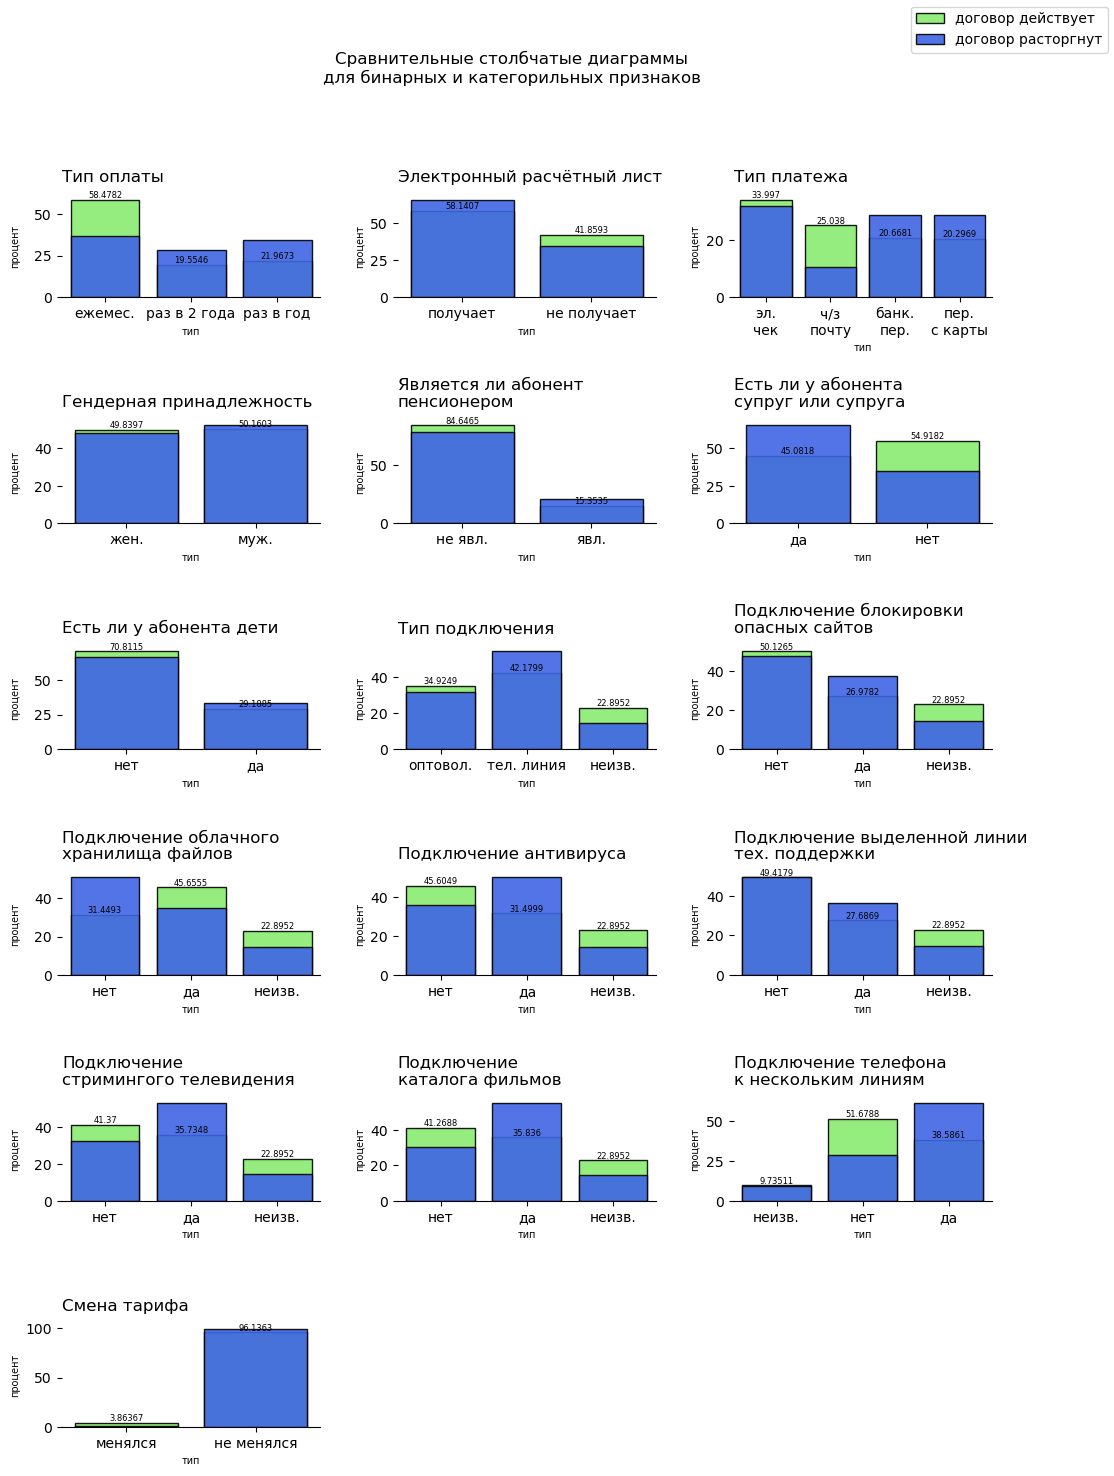

In [49]:
count_plt(joined_df.query('left==0'),joined_df.query('left==1'), tuple_plt, [6,3], 2)

</font><font color='Blue'><b>Коммментарий</b></font><br><div style="height: 200px; overflow-y: scroll; ;">

Построил сравнительные столбчатые диаграммы для бинарных и категорильных признаков при помощи функции `count_plt`. Подписи на столбцах указывают процент действующих пользователей по типу.


⚠**Осторожно, далее следует простыня из "На диграмме с ... видно.."- предложений**⚠

На диграмме с типом оплаты видно, что при `ежемесячном` типе оплаты *больший* процент оставшихся клиентов, а при оплате `раз в два года` и  `раз в год` *меньший*;

На диграмме, которая показывает, `получает` (получал) ли абонент электронный расчетный лист видно, что среди абонентов, которые получают эл. расчет *больше* тех, кто расторгает договов, чем среди тех, что `не получают`;

На диграмме с типом платежа можно увидеть, что при типе платежа через `электронную почту` или `электронным чеком` абоненты *реже* расторгают договор, чем абоненты, которые оплачивают услуги при помощи `банковского перевода` или при помощи `карты`;

На диграмме с полом абонента видно, что немного, но *чаще* `мужчины` расторгают договор, чем женщины;

На диграмме, которая показывает, является ли абонент пенсионером видно, что `персионеры` *чаще* расторгают договор (думал, что наоборот);

На диграмме, которая показывает, есть ли у абонента супруг или супруга можно увидеть, что *чаще* договор продолжает действовать у клиентов `без супруга (суприги)`;

На диаграмме, которая показывает, есть ли у абонента дети, видно, что абоненты `с детьми` *чаще* расторгают договор;

На диаграмме c типом подключения можно увидеть, что *реже* расторгают договор абоненты `с оптоволокном`, чем абоненты `с подключением по телефонной линии` или абоненты тип подключения которых мы не знаем;

На диаграмме, которая показывает подключена ли блокировка опасных сайтов, видно, что договор *чаще* расторгают абоненты `с блокировкой`;

На диаграмме, которая показывает подключено ли облачное хранилище файлов, видно, что договор *чаще* расторгают абоненты `с облачным хралищем`;

На диаграмме, которая показывает подключен ли у абонента антивирус, видно, что договор *чаще* расторгают абоненты `с антивирусом`;

На диаграмме, которая показывает подключена ли у абонента веделенная линия тех.поддержки, видно, что договор *чаще* расторгают абоненты `с тех.поддержкой`;

На диаграмме, которая показывает подключено ли у абонента стриминговое телевидение, видно, что договор *чаще* расторгают абоненты `со стриминговым телевидением`;

На диаграмме, которая показывает подключена ли у абонента услуга "каталог фильмов", видно, что договор *чаще* расторгают абоненты `с каталогом`;

На диаграмме, которая показывает подключен ли у абонента телефон к нескольким линиям, видно, что договор *чаще* расторгают абоненты `с несколькими линиями`;

На диаграмме, которая показывает менял ли абонент тариф или нет видно, что *немного чаще* договор расторгают клиенты, у которых не менялся тариф.
</div>

In [50]:
def plotys_b(df, x, hue=None, title='', xlab=''):

    fig, ax = plt.subplots(figsize=(12,4))

    palette = ['#7bff5c',"#2456ff"]    

    sns.kdeplot(df, x=x, hue=hue, palette=palette, ax=ax, common_norm=False)
    sns.rugplot(df, x=x, hue=hue, palette=palette, alpha=.2,height=.05)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel('плотность')
    ax.legend(['договор действует','договор расторгнут'])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

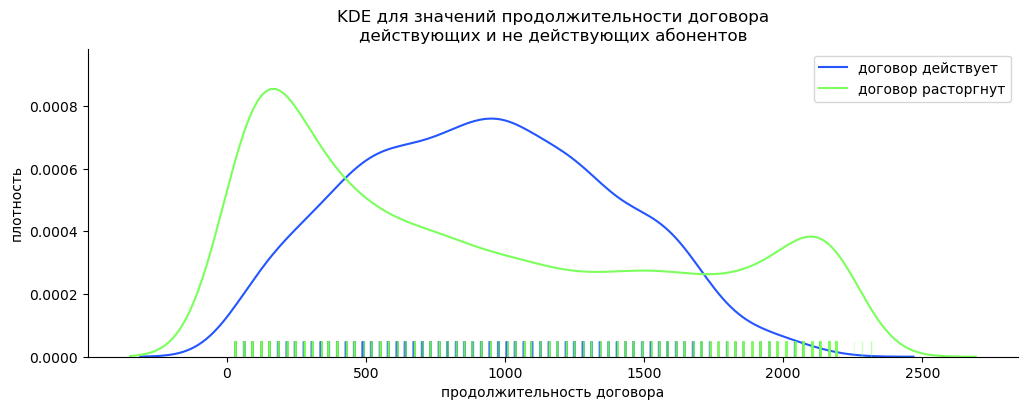

In [51]:
plotys_b(joined_df, x='days_reg', hue='left',
         title='KDE для значений продолжительности договора\nдействующих и не действующих абонентов',
         xlab='продолжительность договора')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил график ядерной оценки плотности наборов значений `продолжительности договоров` для клиентов, которые расторгли договор и для действующих клиентов. На графике видно, что данные в выборках имеют разные распределения, в значениях продолжительности договора действующих клиентов есть несколько пиков, что может говорить о наличии кластеров. Явных выбросов не заметил.

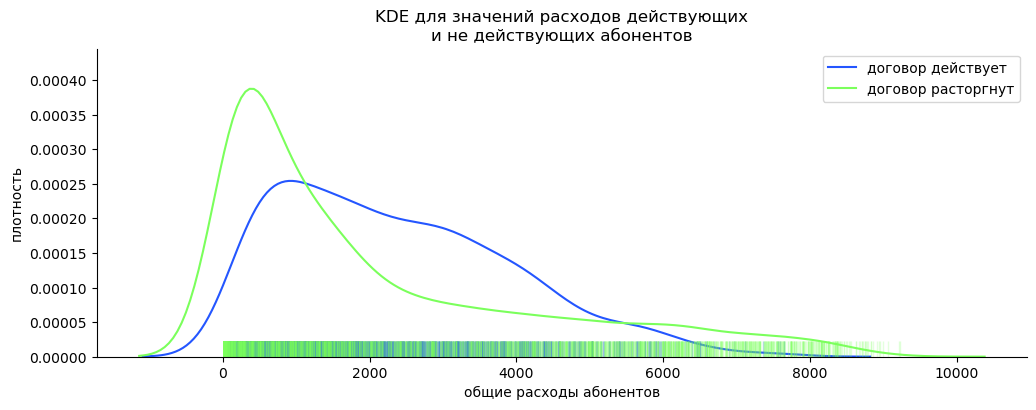

In [52]:
plotys_b(joined_df, x='total_charges', hue='left',
         title='KDE для значений расходов действующих\nи не действующих абонентов',
         xlab='общие расходы абонентов')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил график ядерной оценки плотности наборов значений `общих расходов` для клиентов, которые расторгли договор и для действующих клиентов. На этом графике видно, что данные также имеют разные распределения со смещением и в этих наборах можно выделить несколько кластеров.

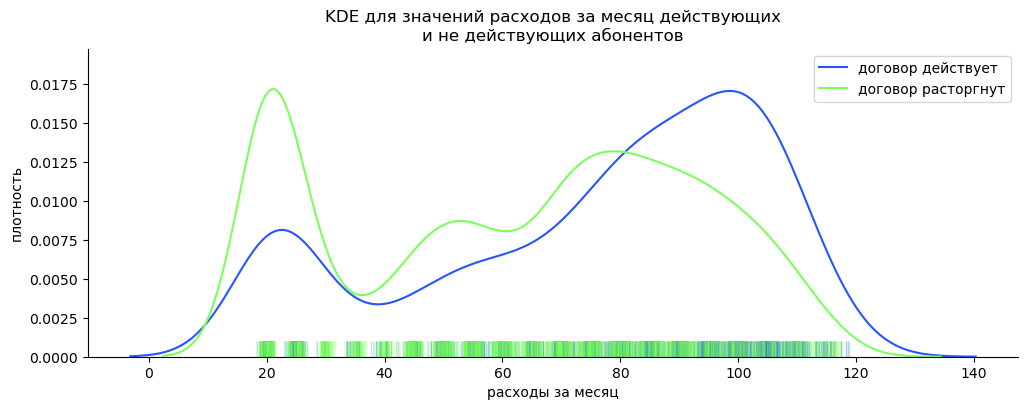

In [53]:
plotys_b(joined_df, x='monthly_charges', hue='left',
         title='KDE для значений расходов за месяц действующих\nи не действующих абонентов',
         xlab='расходы за месяц')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил график ядерной оценки плотности наборов значений `расходов за месяц` для клиентов, которые расторгли договор и для действующих клиентов. На этом графике видно, что данные также имеют разные распределения, есть несколько вершин и можно выделить несколько кластеров.

</font><font color='Blue'><b>Коммментарий</b></font><br>

На графиках с распределениями отчетливо видно, что самое большое количество абонентов уходит в первый год, общие расходы у ушедших абонентов не превышают 1000 ед. и расходы за месяц не превышают 30 ед. Можно предположить, что у компании проходили какие - то акции и по завершению действия неких условий тарификации абоненты расторгали договор.

## Исследовательский анализ и предобработка данных объединённого датафрейма. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

В процессе исследовательского анализа и предобработки данных объединённого датафрейма:

* были обнаружены и удалены дубликаты, которые образовались после объединения датафреймов;
* были обнаружены пропуски, которые были заполнены заглшкой `unknown`;
* были обнаружены и удалены строки, в которых встретились пробелы вместо числовых значений;
* был выделен целевой признак;
* был уставлен правильный тип данных для колонок с ошибками в них;
* была построена матрица корреляций на основе которой были выделены самые значимые признаки, которыми оказались дата заключения договора и его длительность, общее количество расходов абонента и семейное положение абонента;
* был проведен анализ бинарных и категорильных признаков и для признаков с непрерывными величинами и сделаны выводы на его основе о том, как влияют значения признаков на то, может ли абонент разорвать договор в скором времени или нет.

# Разработка признаков

In [54]:
joined_df['service_count'] = joined_df[df_list[1].columns[2:]].apply(lambda x: (x=='Yes').sum(), axis=1)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил признак `service_count` с количеством подключенных услуг.

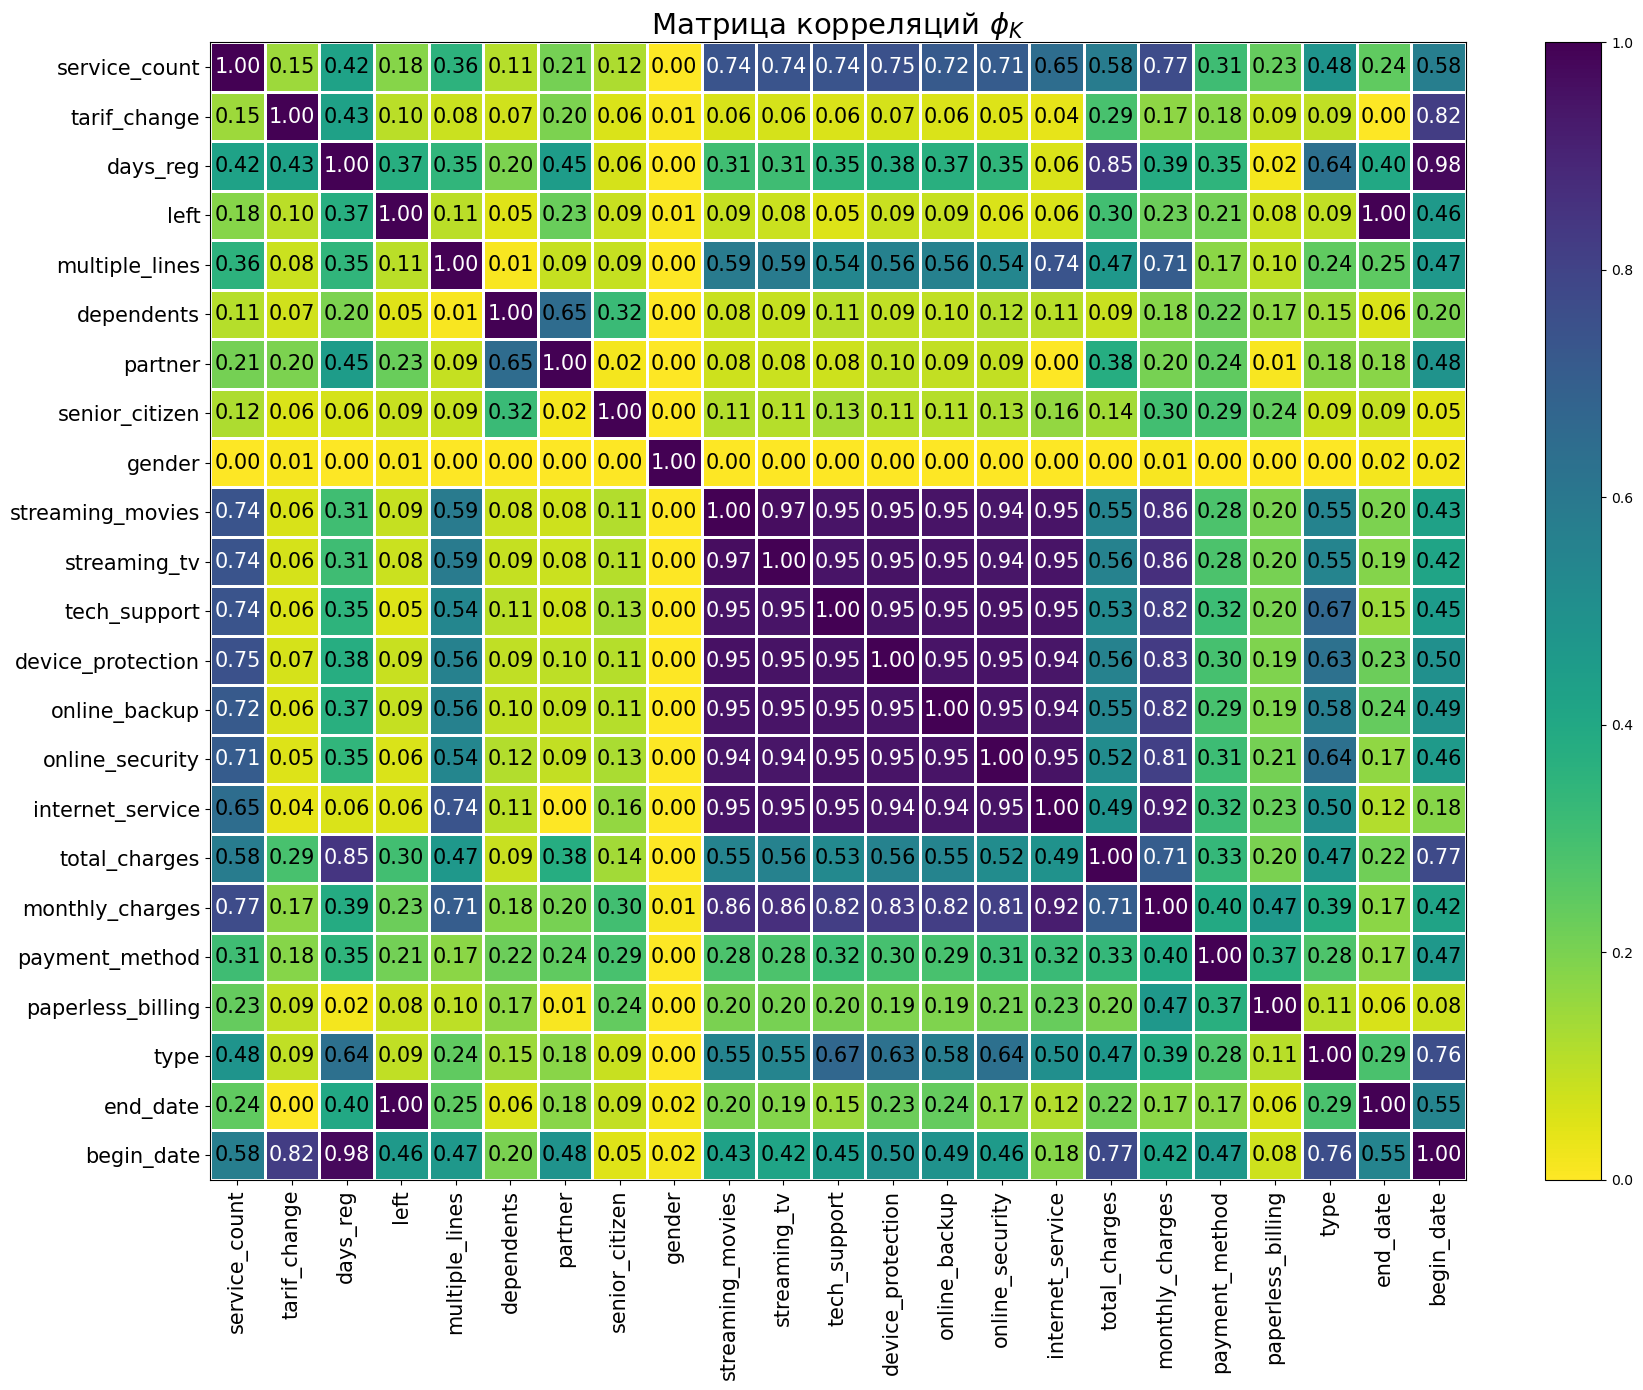

In [55]:
phik_overview = phik_matrix(joined_df, interval_cols = ['days_reg',  'total_charges', 'monthly_charges'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='viridis_r',
    title=r'Матрица корреляций $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Снова построил матрицу корреляций для значений из основного датафрейма, в том числе с новыми признаками. На основе диаграммы можно сделать следующие выводы:

 * все преобразованные признаки имеют более высокие коэффициенты корреляции, чем признаки, на которых они были основаны;
 * все преобразованные признаки имеют коэффициенты больше 0.9 только с признаками, на которых они были основаны;
 * признаки, которые были добавлены имеют коэффициенты корреляции отличные от нуля и не равные единице.


In [56]:
joined_df.drop(['streaming_tv',
                'tech_support',
                'device_protection',
                'online_backup',
                'online_security',
                'end_date',
                'begin_date',
                'streaming_movies',
                'monthly_charges'
               ], axis=1, inplace=True)

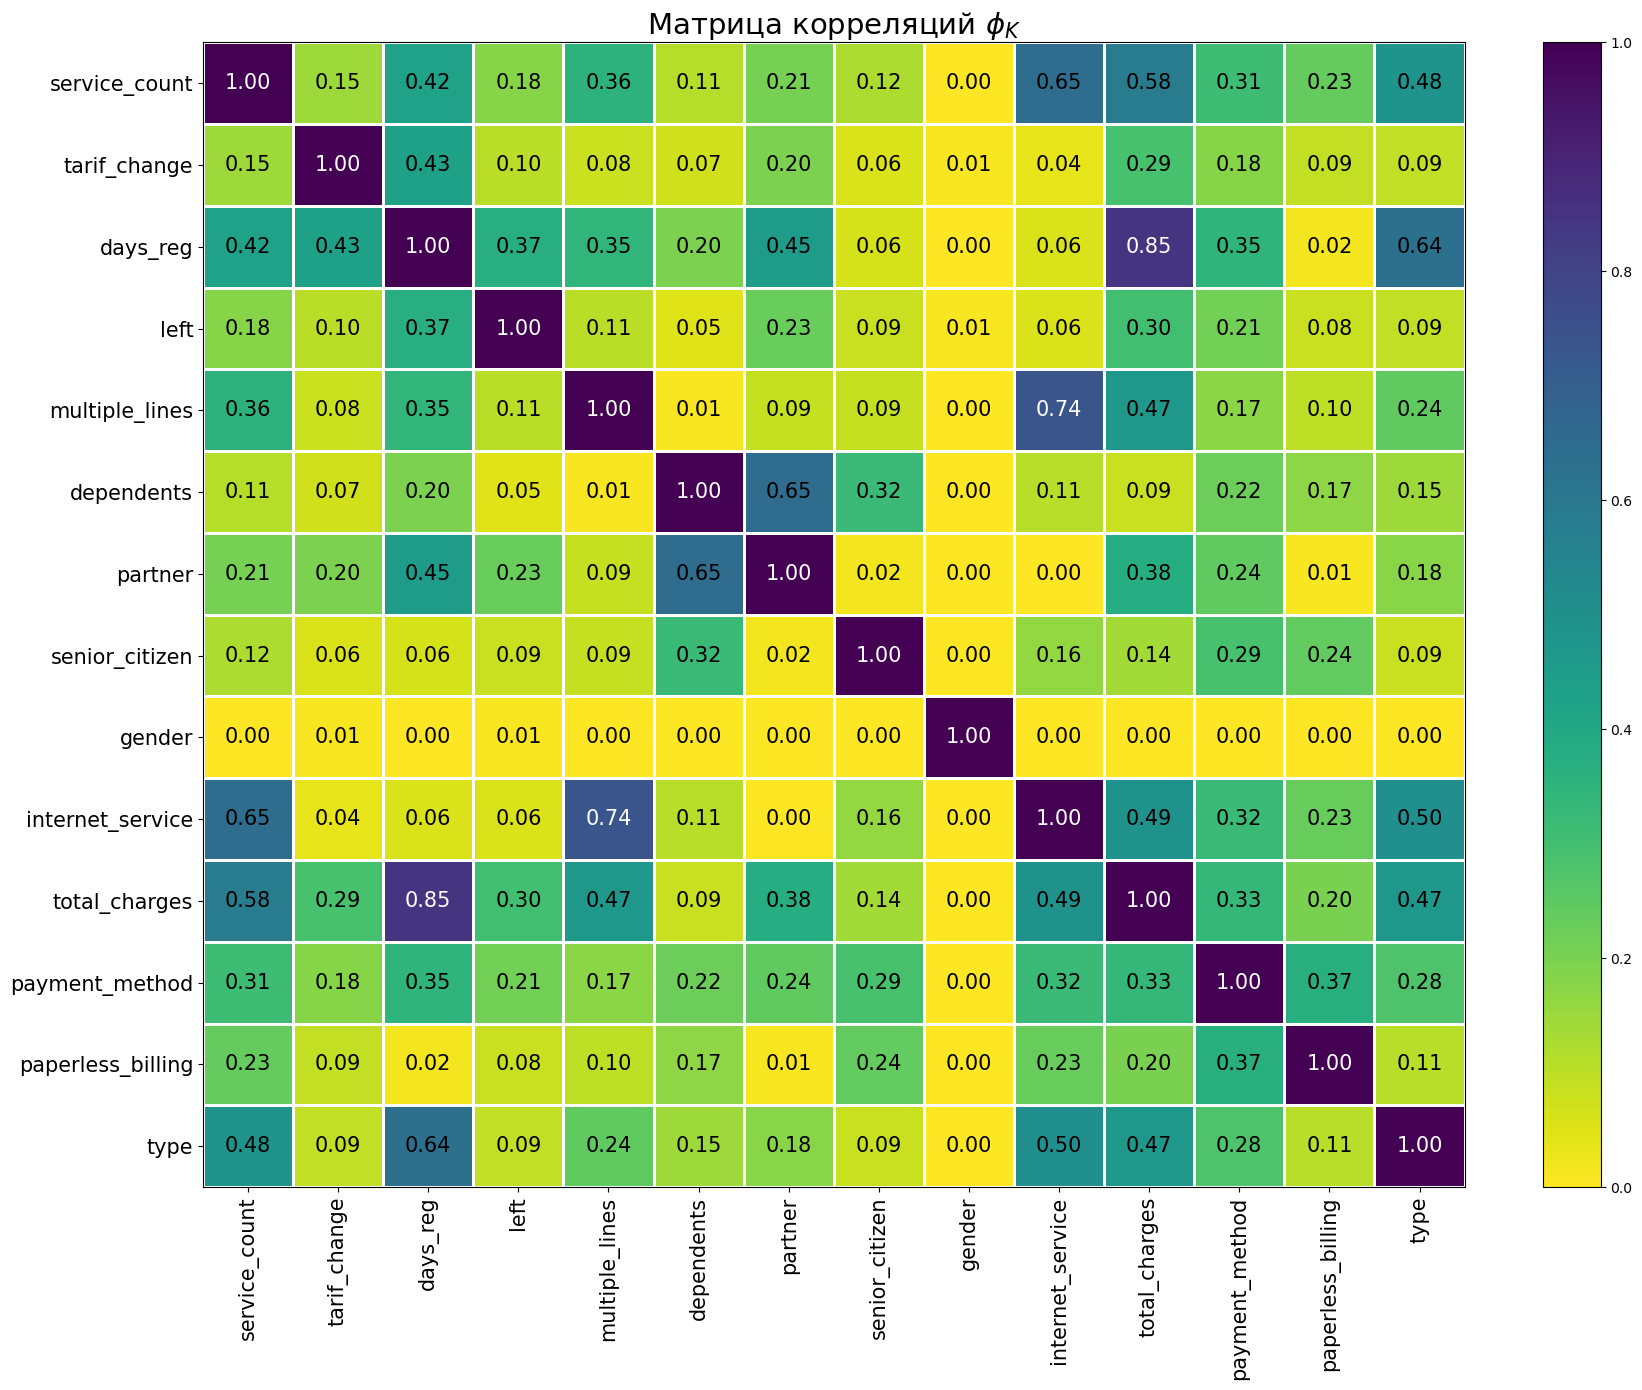

In [57]:
phik_overview = phik_matrix(joined_df, interval_cols = ['days_reg',  'total_charges', 'monthly_charges'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='viridis_r',
    title=r'Матрица корреляций $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Удалил признаки, которые имеют мультиколлинеарность.

После удаления признаков снова построил матрицу корреляций для значений из итогового датафрейма. На основе диаграммы можно сделать следующие выводы:

 * признаки, которые были добавлены имеют коэффициенты корреляции отличные от нуля и не равные единице,
 * отсутствуют мультиколлинеарные признаки.


## Разработка признаков. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

После разработки признаков:
* был создан признак `service_count`;
* при помощи методов визуализации были выявлены признаки, которые подлежат удалению из набора входных признаков;
* были удалены признаки, которые имеют мультиколлинеарность.

# Подготовка данных

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    joined_df.drop(['left'], axis=1),
    joined_df['left'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = joined_df['left'])

</font><font color='Blue'><b>Коммментарий</b></font><br>

Разделил данные на тренировочную и тестовую выбоки, выборки стратифицировал, так как в данных присутствует дисбаланс целевого признака.

In [59]:
ohe_columns=['paperless_billing', 'senior_citizen', 'partner', 'dependents','tarif_change']

ord_columns=['type', 'payment_method','multiple_lines', 'gender', 'internet_service']

num_columns=['days_reg','total_charges','service_count']

</font><font color='Blue'><b>Коммментарий</b></font><br>

Разделил признаки на бинарные, категорильные и количественные.

# Обучение моделей машинного обучения

In [60]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
   ])


In [61]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [62]:
p_wei = y_train.value_counts()[0]/y_train.value_counts()[1]

In [63]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10)  
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight = 'balanced', probability=True)],
        'models__degree': range(2,7),
        'models__kernel': ['poly','rbf']
    },
 
    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            verbosity=2,
            scale_pos_weight = p_wei,
            max_delta_step = 1,
            max_depth=2)],

        'models__n_estimators': range(1000, 1600, 100),
        'models__learning_rate': [0.17, 0.15]       
    }
    
]

In [64]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [65]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

</font><font color='Blue'><b>Коммментарий</b></font><br>

Сформировал пайплайн для подбора лучшей модели и ее гиперпараметров.

In [66]:
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[11:25:45] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (5271, 13, 68523).


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['paperless_billing',
                                                                                'senior_citizen',
                                                                                'partner',
                                                                                'dependents',...
                                                                  max_cat_threshold=None,
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=1,
                                                                  max_depth=2,
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=None,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None, ...)],
                                         'models__learning_rate': [0.17, 0.15],
                                         'models__n_estimators': range(1000, 1600, 100)}],
                   random_state=201025, scoring='roc_auc', verbose=2)

In [67]:
print(f'ROC-AUC модели на валидационной выборке: ~{round(random_search.best_score_, 4)}')
print(f'ROC-AUC модели на тестовой выборке: ~{round(roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:,1]),4)}')
print(f'lr модели: {random_search.best_estimator_.get_params()['models__learning_rate']}')
print(f'Максимальная глубина модели: {random_search.best_estimator_.get_params()['models__max_depth']}')
print(f'Количество итераций: {random_search.best_estimator_.get_params()['models__n_estimators']}')

ROC-AUC модели на валидационной выборке: ~0.9181
ROC-AUC модели на тестовой выборке: ~0.931
lr модели: 0.17
Максимальная глубина модели: 2
Количество итераций: 1500


</font><font color='Blue'><b>Коммментарий</b></font><br>

Подобрал лучшую модель и ее гиперпараметры при помощи RandomizedSearchCV: ей оказалась модель `XGBoost` с `lr 0.17` и `1500` итерациями.
    
</div>

## Обучение моделей машинного обучения. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

Для выбора лучшей модели был использован пайплай, в котором были преобразованы признаки и проверен ряд моделей таких как:

* `SVC` - метод опорных векторов для классификации;
* `DecisionTreeClassifier` - дерево решений;
* `XGBoost` - модель градиентного бустинга для классификации.



Лучшей моделью оказалась модель `XGBoost` с lr 0.17, максимальной глубиной 2 и с 1500 итерациями. 


Модель достигла значения метрики `ROC-AUC` около 0.92, а на тестовой около 0.93, что удовлетворяет запросу заказчика.

In [68]:
ffeatures = random_search.best_estimator_.named_steps.preprocessor.get_feature_names_out()

ffeatures = [re.sub(r'.*\_{2}','', f) for f in ffeatures]

X_test_trans = pd.DataFrame(random_search.best_estimator_[0].transform(X_test),columns=ffeatures)

In [69]:
explainer = shap.Explainer(random_search.best_estimator_[-1].predict, X_test_trans)
shap_values = explainer(X_test_trans)

PermutationExplainer explainer: 1758it [04:31,  6.27it/s]                                    


</font><font color='Blue'><b>Коммментарий</b></font><br>

Получил значения Шепли для признаков тестовой выборки.

In [70]:
def sh_bar():
    shap.plots.bar(shap_values,show=False, max_display=shap_values.shape[1]);
    fig, ax = plt.gcf(), plt.gca()
    ax.set_ylabel("входной признак", fontsize=17)
    ax.set_xlabel("среднее значение Шепли", fontsize=17)
    plt.title('столбчатая диаграмма значений Шепли',fontsize=20)
    plt.grid(color='blue',linestyle=':',alpha=0.7)
    plt.show();

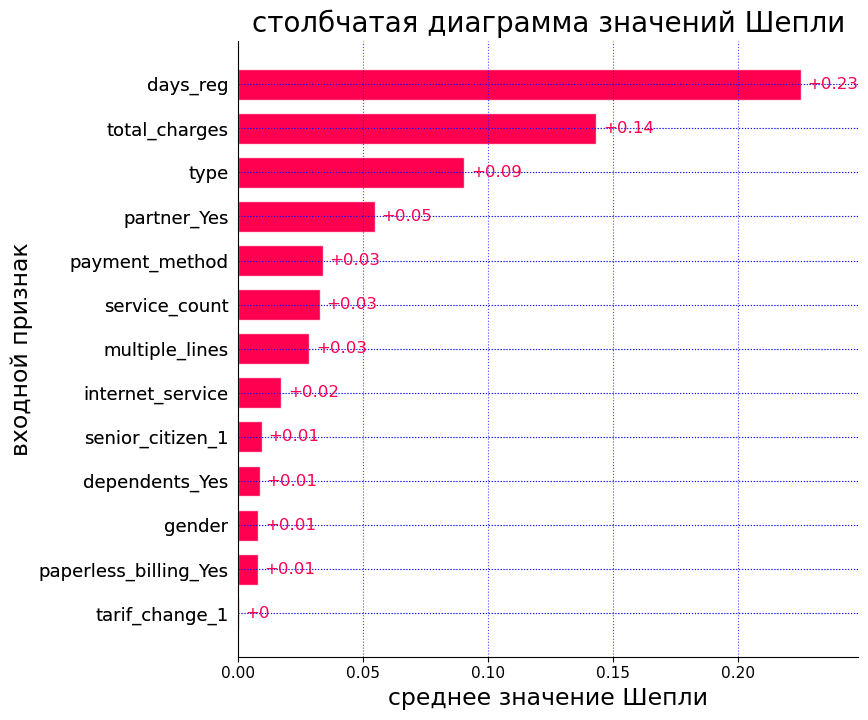

In [71]:
sh_bar()

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил столбчатую диаграмму для значений Шепли. Из диаграммы видно, что самое большое значение при предсказании модели оказали следующие признаки:

* признак с длительностью контракта;
* тип оплаты: раз в год-два или ежемесячно;
* признак наличия супруга или супруги;
* признак размера платежа за месяц;
* тип платежа.

In [72]:
def sh_bee(plot_size=[11,7]):

    fig, ax = plt.subplots()
    plt.sca(ax)
    shap.summary_plot(shap_values, plot_size=plot_size,show=False, alpha=0.3);#, max_display=10,
    
    
    ax.tick_params(labelsize=13)
    ax.set_ylabel("входной признак", fontsize=17)
    ax.set_xlabel("значение Шепли", fontsize=17)
    ax.set_title('Диаграмма Beeswarm признаков Шепли',fontsize=21, y=1.04)

    
    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=13)
    cb_ax.set_ylabel("значение признака", fontsize=17)
    cb_ax.set_yticklabels(['мин.','макс.'])
   
    
    plt.grid(color='blue',linestyle=':')

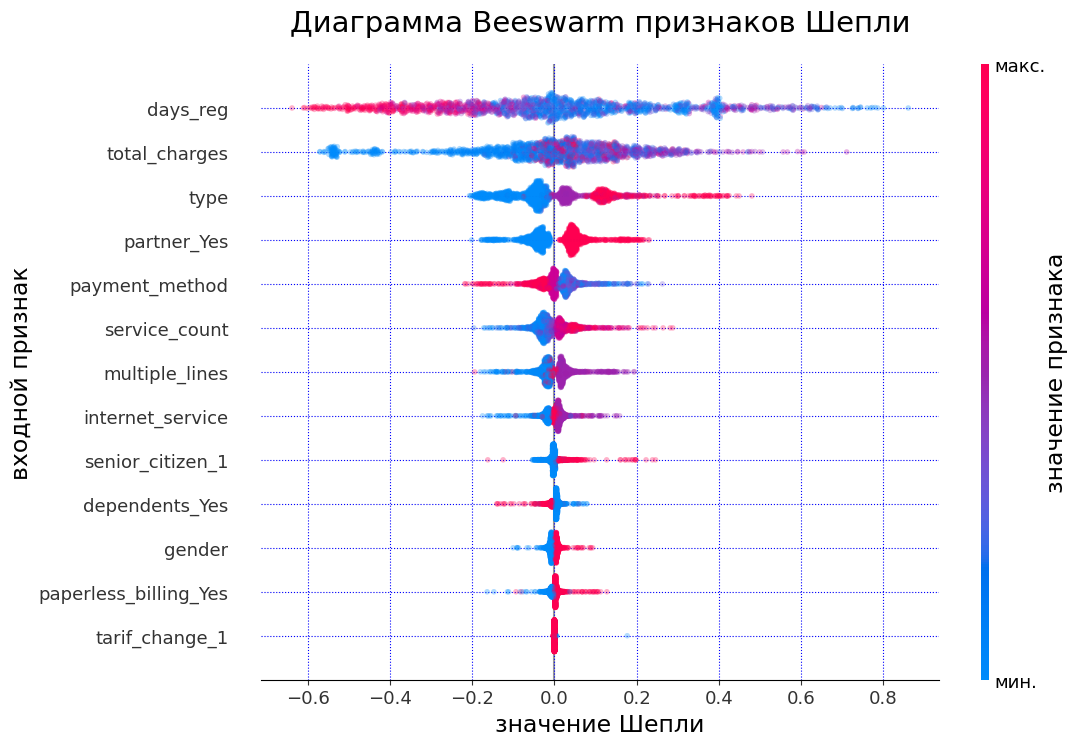

In [73]:
sh_bee()
plt.show()

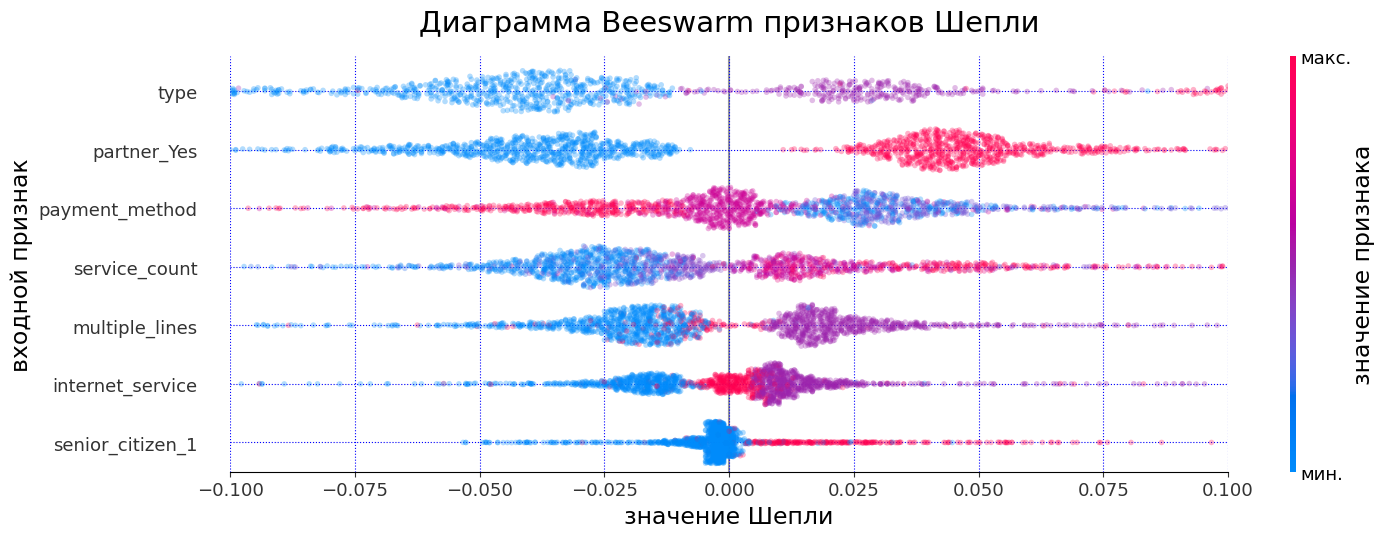

In [74]:
sh_bee([15,5])
plt.ylim([3.5,shap_values.shape[1]-2.4])
plt.xlim([-0.1,0.1])
plt.show()

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил диаграмму Beeswarm для значений Шепли. Из диаграммы видно, что 

* чаще всего абоненты разрывают договор при низких значениях длительности контракта;
* с ростом размера общих расходов растет вероятность того, что абонент уйдет;
* абоненты реже разрывают договор при ежемесячной оплате;
* реже разрывают договор абоненты без партнеров.

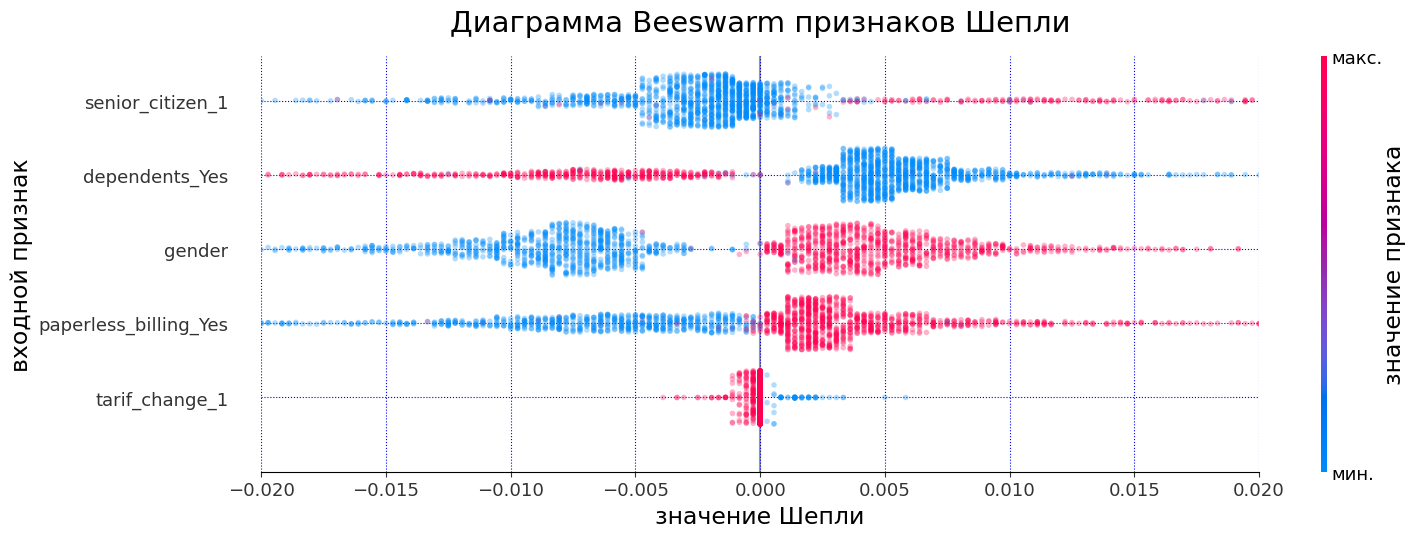

In [75]:
sh_bee([15,5])
plt.ylim([-1,shap_values.shape[1]-8.4])
plt.xlim([-0.02,0.02])
plt.show()

</font><font color='Blue'><b>Коммментарий</b></font><br>

Диаграмму Beeswarm на которой отражены признаки с небольшим вкладом оставил специально, чтобы показать, что они все равно участвуют в предсказании. Например, если у абонента нет детей, то он с немного большей вероятностью уйдет.

In [76]:
def pred_df():
    pred = random_search.best_estimator_.predict(X_test)
    p_df = pd.DataFrame(zip(pred, y_test), columns=['pred', 'true'], index=range(X_test.shape[0]))
    return p_df

In [77]:
pred_df = pred_df()

In [78]:
pred_df.head(3)

,pred,true
0,0,0
1,1,1
2,0,0


In [79]:
false_pred = pred_df.query('pred!=true')

In [80]:
false_pred.head(3)

,pred,true
8,1,0
25,0,1
26,1,0


</font><font color='Blue'><b>Коммментарий</b></font><br>

Написал функцию для формирования датафрейма из предсказаний и истиных значений. Создал датафрейм `'false_pred'` с ошибками, которая допустила модель.

In [81]:
def random_sh(values,fp):
    
    sample = fp.sample(4)
    sample['error_type'] = sample['pred'].apply(lambda x: 'false negative' if x==0 else 'false positive' )

    fig, axes = plt.subplots(2,2);
    axes = axes.flatten()
    
    for i, val in enumerate(sample.index):
    
        plt.sca(axes[i])
        axes[i].set_title(f'вклад признаков в строке {val}'f'\nошибка: {sample['error_type'][val]}',fontsize=14,x=0.2)
        axes[i].set_xlabel('вклад признака',x=sample['pred'][val]*(sample['pred'][val]-0.15))
        axes[i].set_ylabel('входной признак')
        axes[i].grid(color='blue',linestyle=':',alpha=0.5)
        axes[i]=shap.plots.waterfall(values[val],max_display=10,show=False)
    
    plt.suptitle('Диаграммы четырех случайных ложных предсказаний\nдля оценки вклада признаков', fontsize=20, y=1.04, x=0.45)
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    fig.set_size_inches(16, 12)
    plt.show()

</font><font color='Blue'><b>Коммментарий</b></font><br>

Написал функцию для отображения четырех случайных ложных предсказаний для оценки вклада признаков.

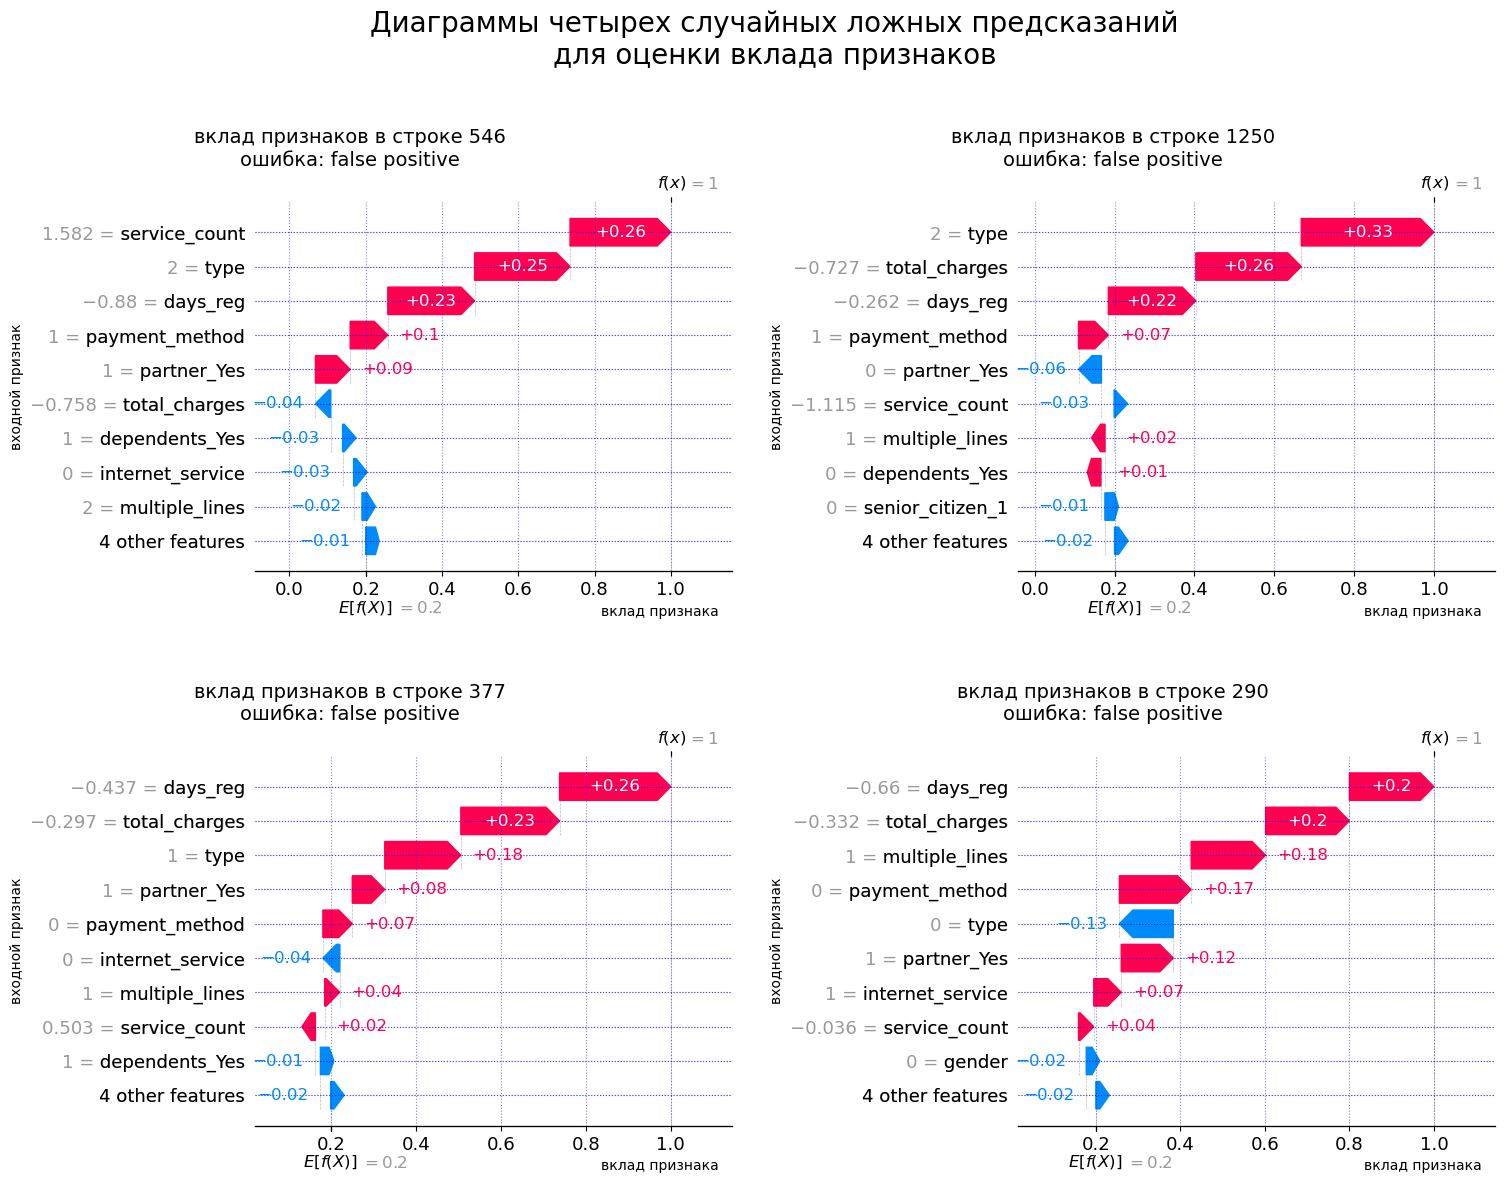

In [82]:
random_sh(shap_values, false_pred)

</font><font color='Blue'><b>Коммментарий</b></font><br>

После нескольких отображений графика не смог обнаружить каких - то закономерностей в ложных предсказаниях, что может говорит о том, что модель ошибается в тех случаях, когда это предсказать нельзя, либо из - за того, что не хватает дополнительных подробностей о клиенте.

# Общий вывод и рекомендации заказчику

Проект был написан для решения одной цели: разработать модель, которая позволит предсказывать, разорвёт ли абонент договор.


Для достижения поставленной цели был решен ряд задач:

* загружены данные;
* проведена предобработка данных;
* были объединены данные;
* был проведен исследовтельский анализ объединены данных;
* разработаны новые признаки и преобразованы имеющиеся;
* проведен корреляционный анализ.


Далее, при помощи пайплайна и автоматического подбора модели и ее гиперпараметров, была найдена лучшая модель для прогноза: ей оказалась модель градиентного бустринга, среднее `ROC_AUC` которой достигло необходимого значения, которое установил Заказчик.

После проведенного анализа признаков модели стало ясно, что самый большой вклад в предсказания модели сделали:

* признак с длительностью контракта (чаще всего абоненты разрывают договор при *низких значениях* длительности контракта);
* признак с размером общих расходов (с ростом размера общих расходов растет вероятность того, что абонент уйдет);
* тип оплаты: раз в год-два или ежемесячно (абоненты реже разрывают договор при *ежемесячной оплате*);
* признак наличия супруга или супруги (реже разрывают договор абоненты *без партнеров*);
* признак размера платежа за месяц;
* тип платежа.

Стоит отметить, что при проведении исследовательского анализа было обнаружено, что самое большое количество абонентов уходит в *первый год*, общие расходы у ушедших абонентов *не превышают 1000 ед.* и расходы за месяц *не превышают 30 ед.* Исходя из этого, можно предположить, что у компании Заказчика проходили какие - то акции и по завершению действия неких условий тарификации абоненты расторгали договор, если клиенты действительно заключили договор только из - за такой акции, то промокоды и специальные условия всем, кто планирует отказаться от услуг связи могут удержать абонентов лишь на период действия специального предложения. 

Возможно, модель можно было бы улучшить, если этого захочет Заказчик, за счет добавления данных об акциях в компании, более точных значениях возраста клиентов, регионах, в которых они проживают.